In [10]:
import datacube
from datacube.storage import masking

dc = datacube.Datacube()

In [11]:
# Prepare the DB query

def buildQuery(p, r, g, b, t1, t2, l) :    
    if l == 'nwt' :
        lat = (62.3768, 63.3062)
        lon = (-114.7038, -112.3989)
    elif l == 'vi' :
        lat = (47.9432, 49.4273)
        lon = (-123.7845, -121.2920)
    elif l == 'hvm' :
        lat = (49.7178, 51.2101)
        lon = (-119.1079, -112.9312)
    elif l == 'fmm' :
        lat = (56.3573, 58.2621)
        lon = (-112.9312, -109.1311)
    else :
        lat = (45.4499, 46.6034)
        lon = (-78.4944, -76.7130)


    LC08_Bands = ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'panchromatic', 'cirrus', 'lwir1', 'lwir2', 'quality']


    query = { 
        'product' : p
        , 'latitude' : lat
        , 'longitude' : lon
        , 'measurements' : [ LC08_Bands[r], LC08_Bands[g], LC08_Bands[b] ]
        , 'resolution' : (-0.0025, 0.0025)
    }

    if (t1 != '') and (t2 != '') :
        query['time'] = (t1, t2)
    
    return query

In [12]:
def plotRGB(data) :

    fake_saturation = 400000

    # Sets all `nodata` values to ``nan``.
    data = mask_invalid_data(data)

    # Isolate the color dimension in an xarray.DataArray, use transpose to make color the last dimension
    rgb = (data.to_array(dim='color'))
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1])) 

    # Filter out pixels where any band is 'saturated'
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))

    # Scale to [0, 1] range for imshow
    rgb /= fake_saturation
    return rgb

In [ ]:
# Select a product
product = 'LC08_scene'

# Select band combination
red = 5
green = 4
blue = 3

red, green, blue = map(lambda x: x + 1,[red, green, blue])

# Select available regions
#nwt            # burn before and after 
#vi             # coastal area
#hvm            # copper mine
#fmm            # oil sands
#pet            # research forest

region = 'pet'

# Select time start and end
start = ''
end = ''

In [ ]:
query = buildQuery(product, red, green, blue, start, end, region)
data = dc.load( **query)
rgb = plotRGB(data)

In [ ]:
rgb.plot.imshow( x = data.crs.dimensions[1], y = data.crs.dimensions[0], col = 'time', col_wrap = 1 , size = 10, add_colorbar = False)

In [24]:
# Use the masking library to see how the bit flags are defined in the dataset
import pandas
pandas.DataFrame.from_dict(masking.get_flags_def(data.quality), orient='index')

,bits,values,description
cirrus_confidence,"[11, 12]","{'0': 'Not Determined', '1': 'Low', '2': 'Medi...","Cirrus Confidence with low =(0-33)%, medium =(..."
cloud,[4],"{'0': False, '1': True}",Cloud
cloud_confidence,"[5, 6]","{'0': 'Not Determined', '1': 'Low', '2': 'Medi...","Cloud Confidence with low =(0-33)%, medium =(3..."
cloud_shadow_conf,"[7, 8]","{'0': 'Not Determined', '1': 'Low', '2': 'Medi...","Cloud Shadow Confidence with low =(0-33)%, med..."
designated_fill,[0],"{'0': False, '1': True}",Used to identify fill values
radiometric_saturation,"[2, 3]","{'0': 'none', '1': '1-2', '2': '3-4', '3': '<=5'}","Radiometric saturation bits, represents how ma..."
snow_ice_conf,"[9, 10]","{'0': 'Not Determined', '1': 'Low', '2': 'Medi...","Snow/Ice Confidence with low =(0-33)%, medium ..."
terrain_occlusion,[1],"{'0': False, '1': True}",Terrain Occlusion


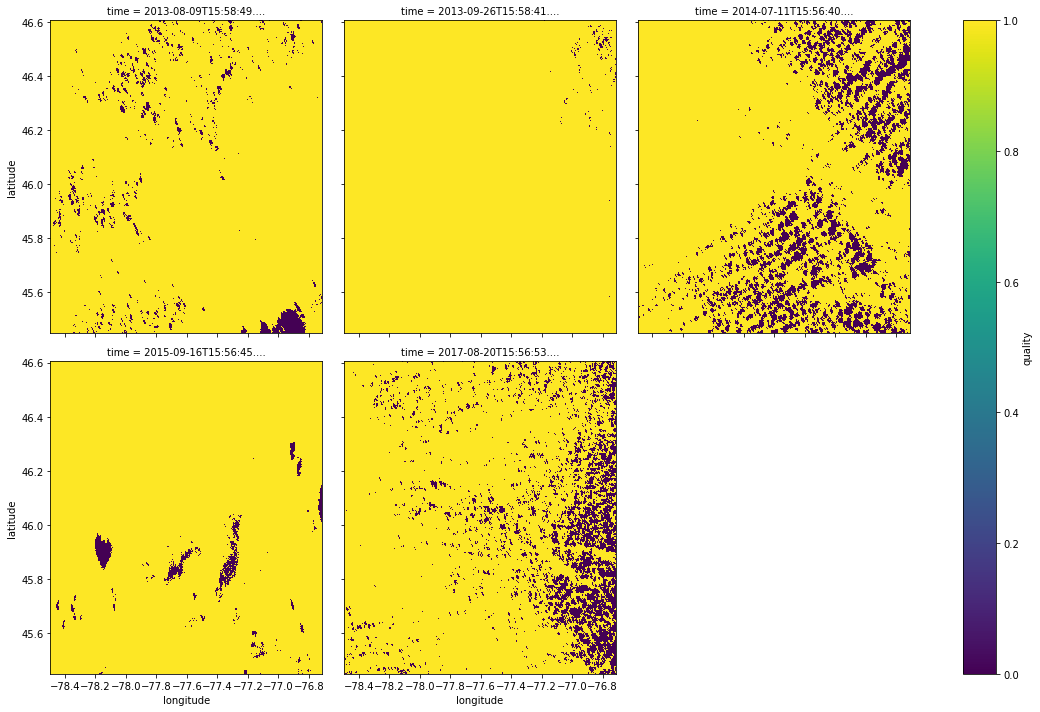

In [25]:
# Make a mask for the quality band,
cloudFree = masking.make_mask(data, cloud = False, cloud_shadow_conf='Low', cloud_confidence='Low', cirrus_confidence = 'Low')
                              
#Visualize mask
cloudFree.quality.plot(col='time', col_wrap = 3, size = 5 )

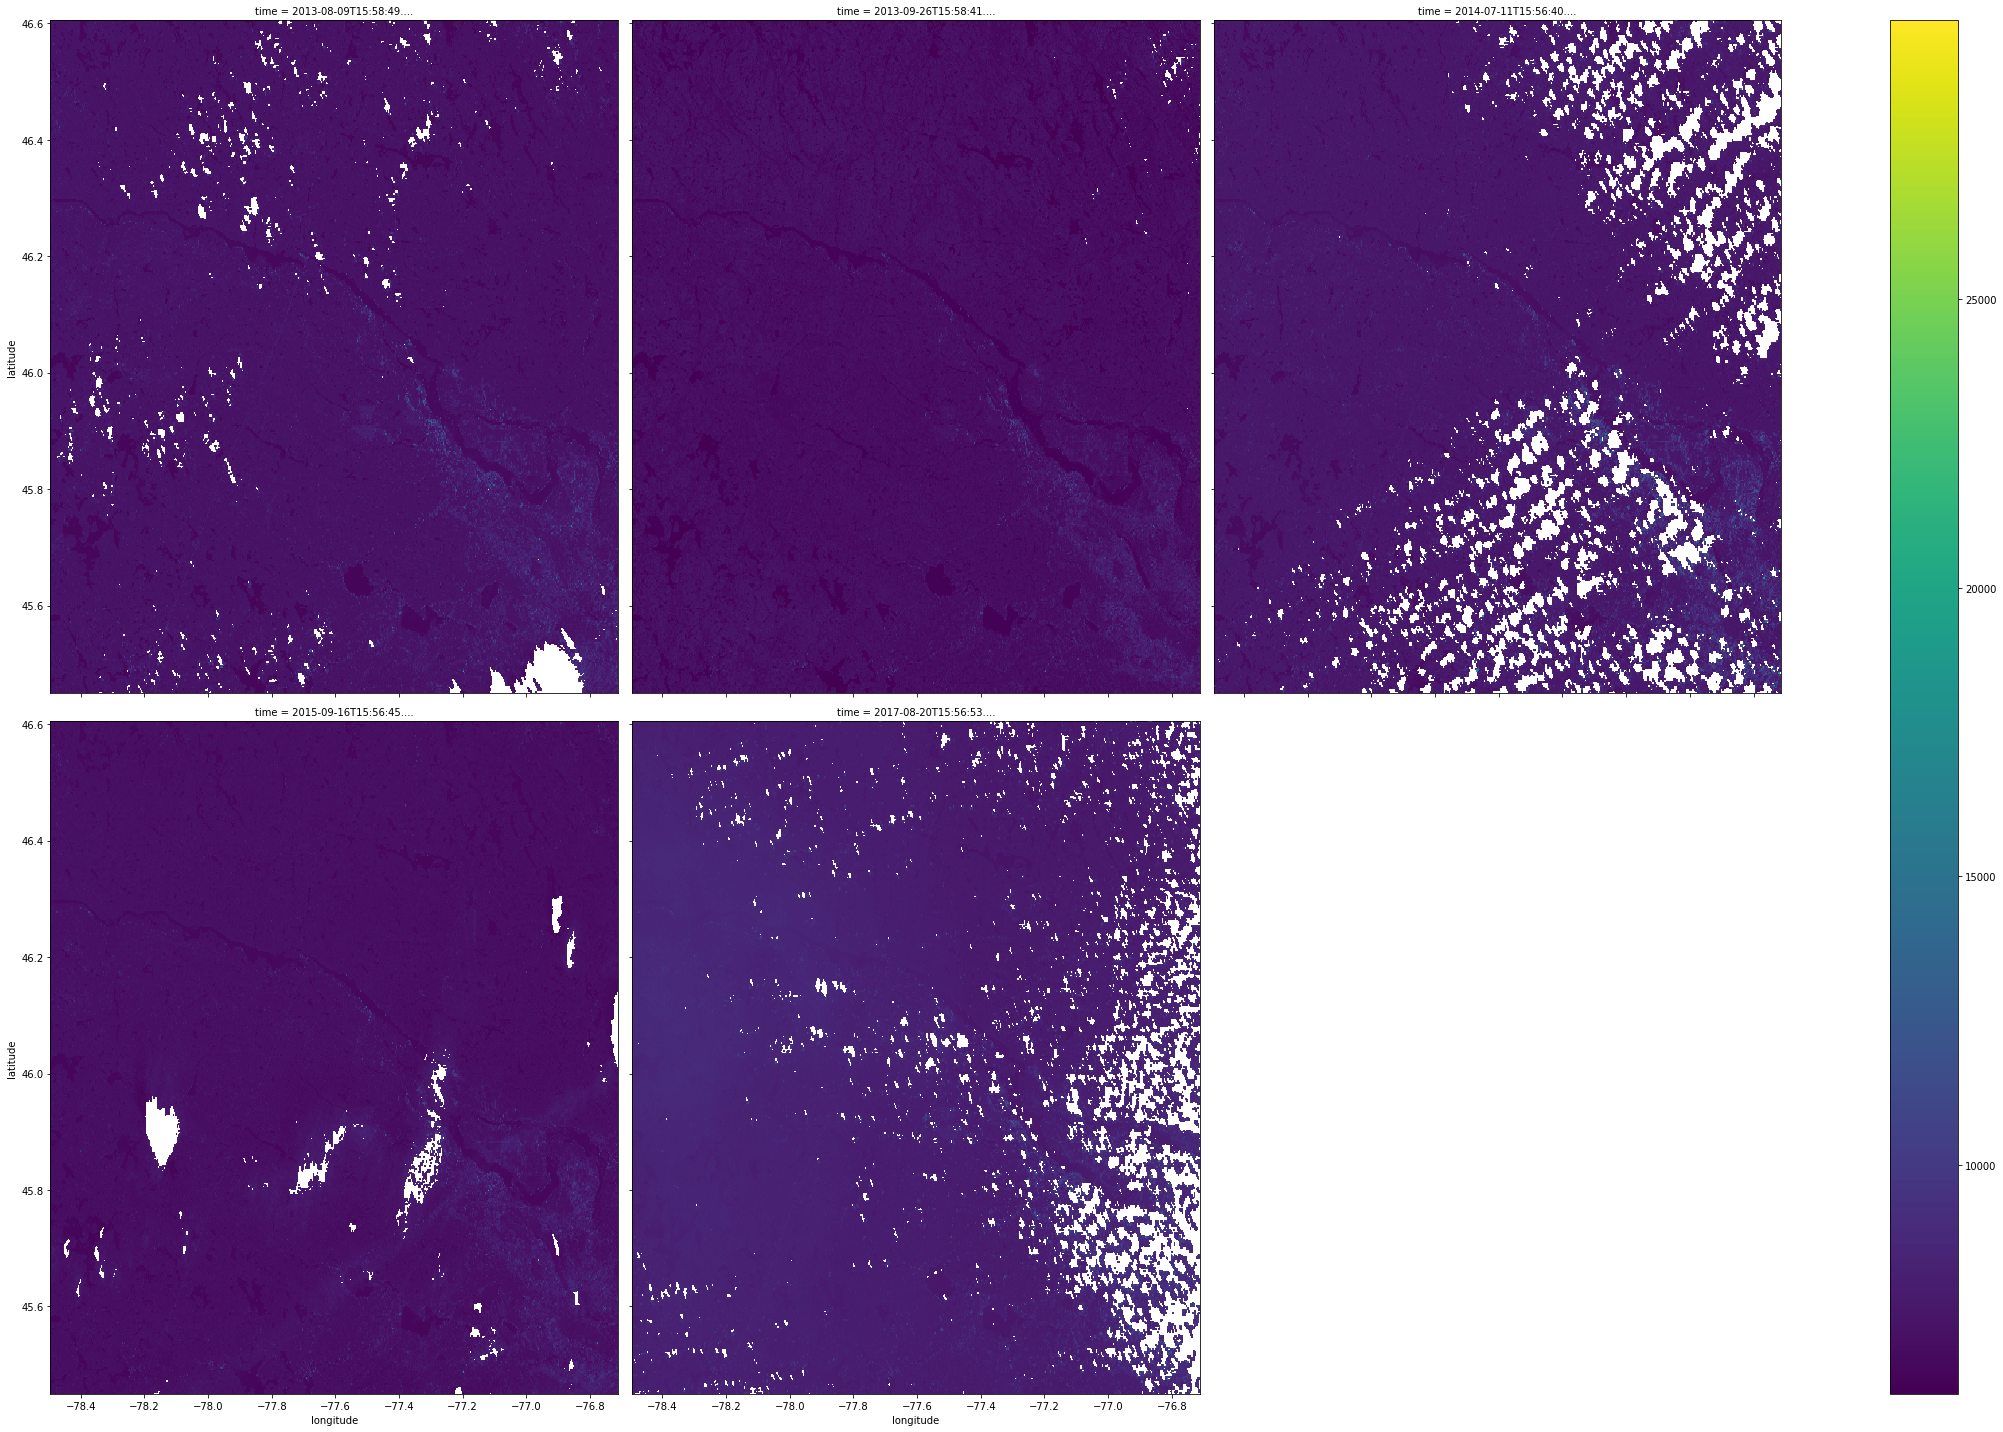

In [27]:
#  Apply mask to band
# condition arguments to where() define the locations at which to preserve this object’s values.
# 'other' argument is the value to use for locations in this object where cond is False. By default, these locations filled with NA.
# This can be used as a threshold mask
cloudFreeData = band.where(cloudFree.quality)
cloudFreeData.plot(col='time', col_wrap = 3, size = 10)